# Overture Maps Buildings

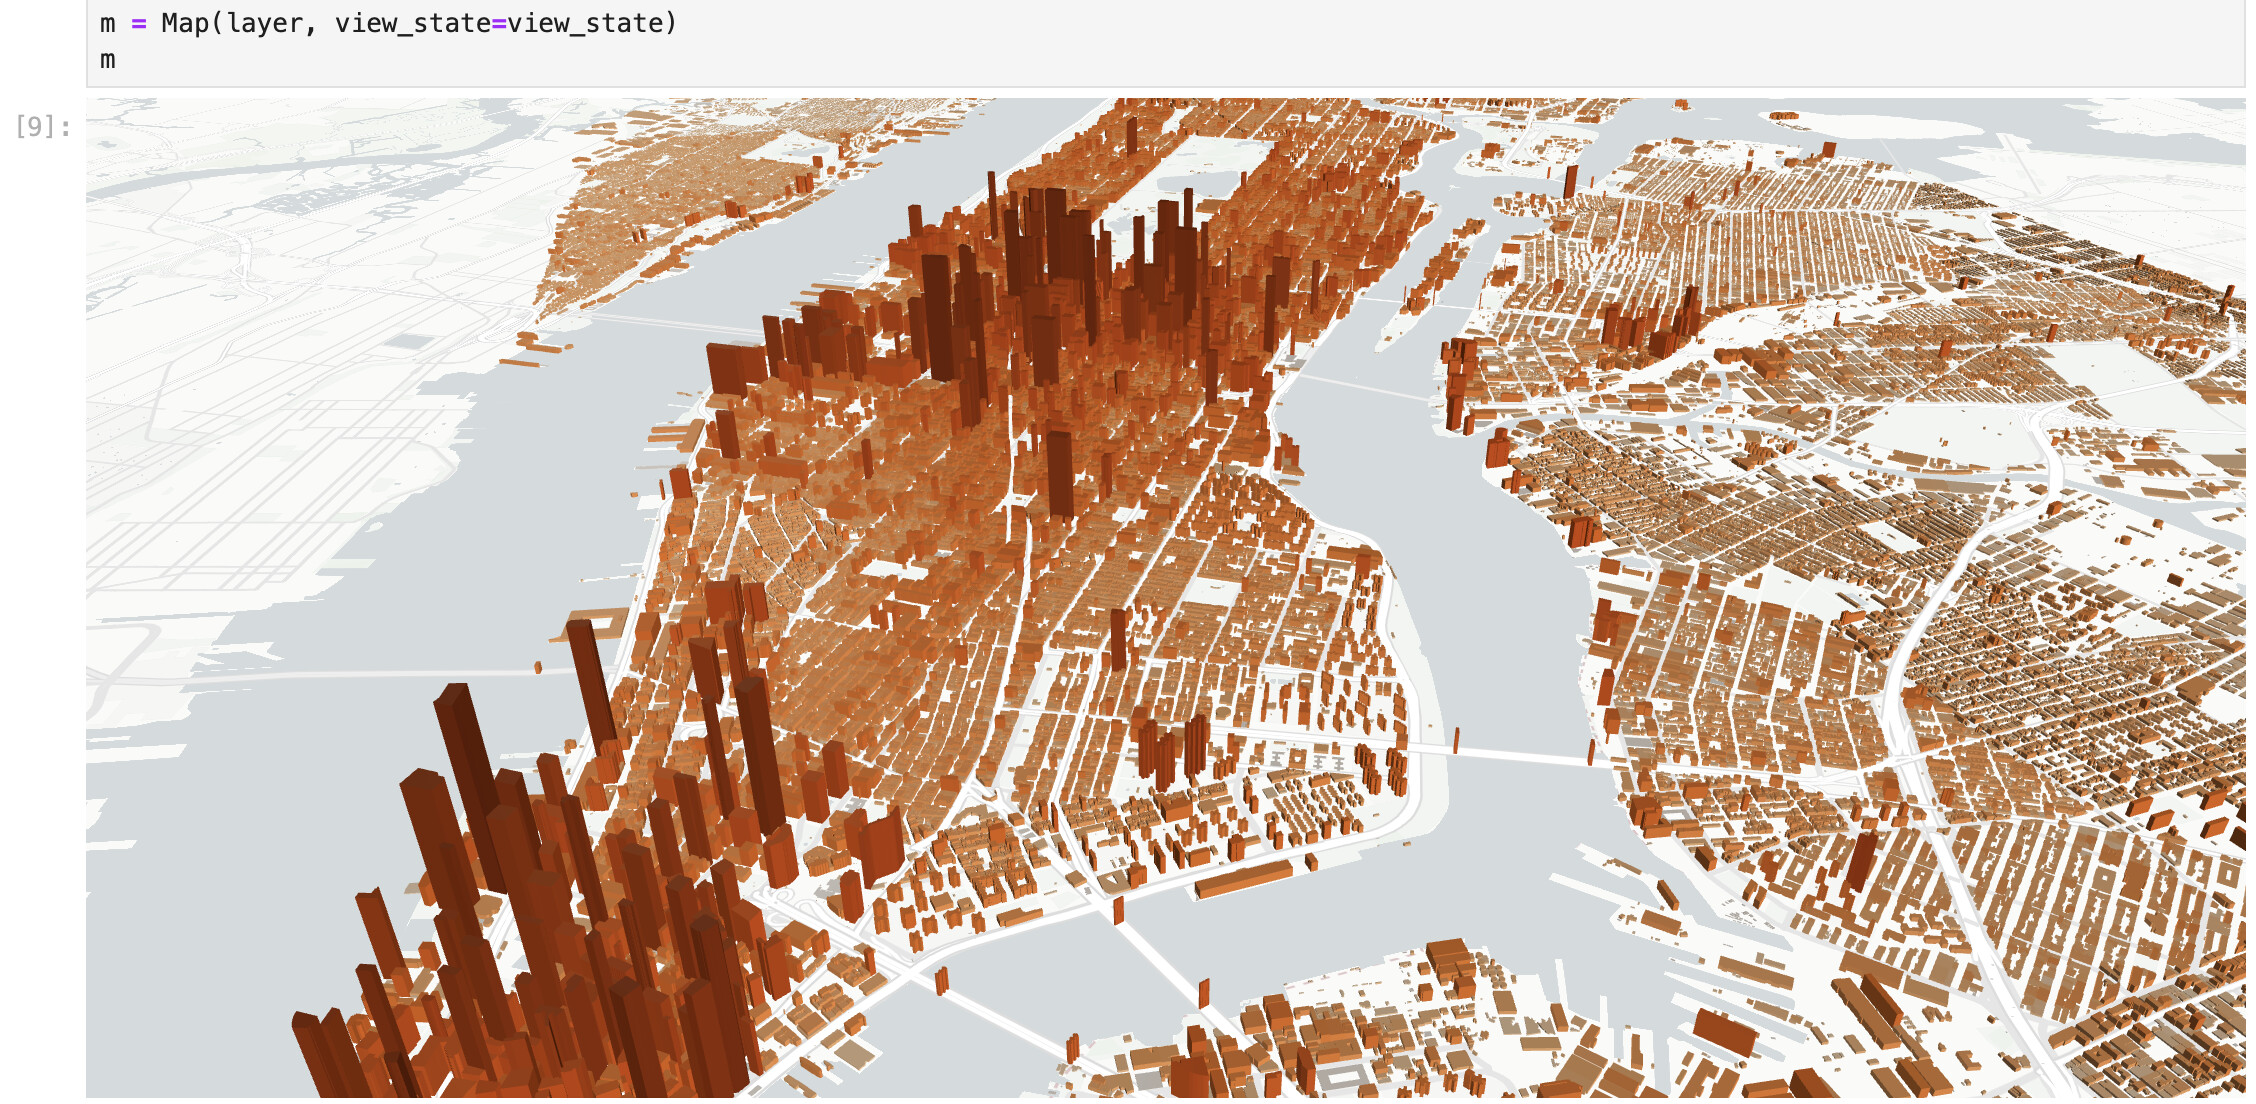

This notebook will give a quick overview of using the new [Overture Maps Python library](https://github.com/OvertureMaps/overturemaps-py) with Lonboard.

We'll pass in a bounding box covering New York City and the Overture Python API will fetch only the data inside that bounding box. While Overture's buildings dataset contains 2.3 rows, by using a relatively small bounding box, we can download data for our query relatively quickly (around 30 seconds on my internet connection).

This uses the latest advancements of the [GeoParquet specification](https://geoparquet.org/). Data is fetched _directly from the cloud_ with no server in the middle!


## Dependendencies

This notebook requires Lonboard (tested with version 0.8) and `overturemaps` (tested with version 0.4). To install `overturemaps`, run:

```
pip install overturemaps
```


## Imports


In [13]:
! pip install overturemaps
! pip install palettable
! pip install lonboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.4/675.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.7 MB/s eta 0:00:00


In [14]:
import numpy as np
import overturemaps
from matplotlib.colors import LogNorm
from palettable.colorbrewer.sequential import Oranges_9

from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_continuous_cmap

Using [this bounding box tool](https://boundingbox.klokantech.com/) we can find a bounding box covering Manhattan. Choose "CSV" in the drop down box, then paste the result in the following cell:


In [15]:
bbox = -74.02169, 40.696423, -73.891338, 40.831263

Ensure you pass the bbox into `overturemaps.record_batch_reader` as in the next line.

`record_batch_reader` returns a [RecordBatchReader](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatchReader.html), an iterator of Arrow RecordBatches. We call `.read_all()` to materialize all batches into memory. This cell fetches the relevant data from the cloud (AWS S3), so it may take a minute to download.


In [16]:
table = overturemaps.record_batch_reader("building", bbox).read_all()

# Temporarily required as of Lonboard 0.8 to avoid a Lonboard bug
table = table.combine_chunks()

Let's color buildings by their heights. First, convert the "height" column to a numpy array, then replace any null values with `1`.


In [17]:
heights = table["height"].to_numpy()
heights = np.nan_to_num(heights, nan=1)

Building heights tend to scale non-linearly. That is, the vast majority of buildings are relatively low, but a few buildings are very tall. So that the low buildings aren't completely washed out, we'll use matplotlib's [`LogNorm`](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LogNorm.html) to normalize these values according to a log scale.


In [18]:
normalizer = LogNorm(1, heights.max(), clip=True)
normalized_heights = normalizer(heights)

Then we can apply a colormap to these heights. For this case, we'll use the [`Oranges_9`](https://jiffyclub.github.io/palettable/colorbrewer/sequential/#oranges_9) colormap.


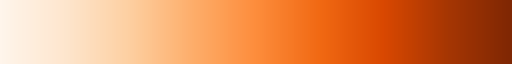

In [19]:
Oranges_9.mpl_colormap

Using [`apply_continuous_cmap`](https://developmentseed.org/lonboard/latest/api/colormap/#lonboard.colormap.apply_continuous_cmap), we can apply our values onto this colormap.


In [20]:
colors = apply_continuous_cmap(normalized_heights, Oranges_9)

We create a `PolygonLayer` with our data, passing in the heights and colors from before.


In [21]:
layer = PolygonLayer(
    # Select only a few attribute columns from the table
    table=table.select(["id", "height", "geometry", "names"]),
    extruded=True,
    get_elevation=heights,
    get_fill_color=colors,
)

/usr/local/lib/python3.10/dist-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


We manually set the view state here for the original NYC data so that the map will start pitched. Remove or change this `view_state` call if you change the input dataset.


In [22]:
view_state = {
    "longitude": -73.98416810282863,
    "latitude": 40.72651721370669,
    "zoom": 12.726630492730596,
    "pitch": 59.80465353190481,
    "bearing": 13.243243243243244,
}
m = Map(layer, view_state=view_state)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x7b63713f3dc0>
[
  11…